# CLF-CBF-QP Controller
My notes about the CLF controller can be found in [this link](https://lopsided-sailfish-2df.notion.site/Lyapunov-Functions-and-Control-Barrier-Functions-232d71044bdf80989298d60b606f56b2).

## The System
The system modeled in this notebook is simply (a simple integrator):
$$
\dot{\vec{x}} = [\dot{x}, \dot{y}] = [vx, vy] = \vec{y}
$$

## Defining the CLF for our system:

$$
V(x) = \frac{1}{2} x^2 + \frac{1}{2} y^2 
$$

Taking the derivative:
$$
\dot{V}(x) = x\dot{x} + y\dot{y}
$$

We then can define our CLF constraint
$$
\dot{V}(x)= x\dot{x} + y\dot{y} + cV(x)\leq 0
$$


## Defining the CBF for our system:

We use a signed distance map to fomulate our CBF.

The distance map is designed as follows:
$$
h = \sqrt{(x - ox)^2 + (y - oy)^2} - r
$$

Where:
$$
[ox, oy]: origin\ of\ cirular\ obstacle
$$
$$
r: radius\ of\ cirular\ obstacle
$$

The lie derivative of the sdf:
$$
\nabla h = [(x-ox), (y-oy)] \frac{1}{ \sqrt{(x - ox)^2 + (y - oy)^2}}
$$

We can then define the cbf constraint to be as follows:
$$
\nabla h u + \alpha h \ge 0
$$

## Formulating the Quadratic-Program

We can then define the following quadratic program where:

$$
argmin ||u|| + \delta^2
$$
Subject to the following constraints:

CLF:
$$
\dot{V}(x)= x\dot{x} + y\dot{y} + cV(x)\leq \delta
$$

CBF:
$$
\nabla h u + \alpha h \ge 0
$$

Where:
$$
\delta: for\ relaxation
$$

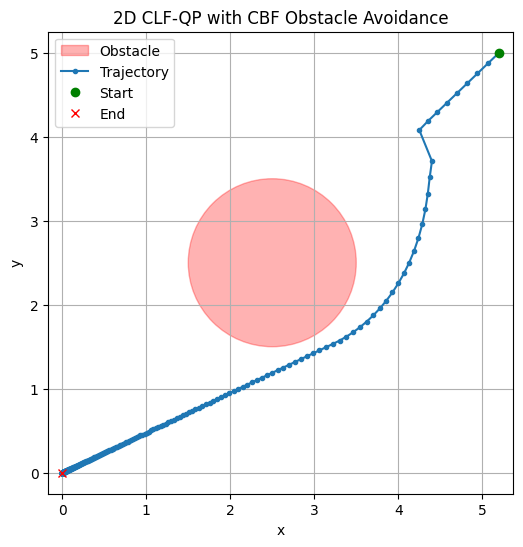

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1000
dt = 0.1
c = 0.5       # CLF rate
alpha = 1.0   # CBF rate
delta_relaxation = 0.0

# Obstacle parameters
ox, oy, r = 2.5, 2.5, 1.0

def make_sdf(x, y):
    dx = x - ox
    dy = y - oy
    return np.sqrt(dx**2 + dy**2) - r

def grad_sdf(x, y):
    norm = np.sqrt((x - ox)**2 + (y - oy)**2)
    return np.array([(x - ox) / norm, (y - oy) / norm])

# Initial state
x, y = 5.2, 5.0
xs, ys = [x], [y]
us = []

for _ in range(N):
    # Control input
    u = cp.Variable(2)

    # CLF constraint
    V = 0.5 * (x**2 + y**2)
    V_dot = x * u[0] + y * u[1]
    clf_constraint = V_dot + (c / 2) * (x**2 + y**2) <= delta_relaxation

    # CBF constraint
    h = make_sdf(x, y)
    grad_h = grad_sdf(x, y)
    h_dot = grad_h @ u
    cbf_constraint = h_dot + alpha * h >= 0

    # Optimization problem
    cost = cp.sum_squares(u) + delta_relaxation**2
    prob = cp.Problem(cp.Minimize(cost), [clf_constraint, cbf_constraint])
    prob.solve()

    # Apply control
    u_val = u.value
    us.append(u_val)
    x += u_val[0] * dt
    y += u_val[1] * dt
    xs.append(x)
    ys.append(y)

# Plot the trajectory
xs = np.array(xs)
ys = np.array(ys)

circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')

plt.figure(figsize=(6, 6))
plt.gca().add_patch(circle)
plt.plot(xs, ys, marker='o', markersize=3, label="Trajectory")
plt.plot(xs[0], ys[0], 'go', label='Start')
plt.plot(xs[-1], ys[-1], 'rx', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D CLF-QP with CBF Obstacle Avoidance')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()
